In [1]:
# Imports
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
from math import pi
from matplotlib.patches import Circle

### Μέρος 1: Ανίχνευση Ακμών σε Γκρίζες Εικόνες

### 1.1. Δημιουργία Εικόνων Εισόδου

### 1.1.1

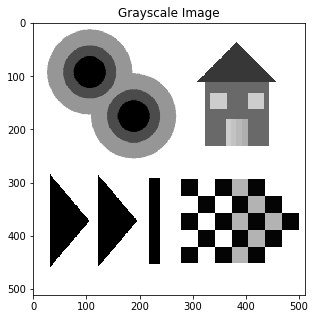

In [2]:
image1_gray = cv2.imread('edgetest_20.png',cv2.IMREAD_GRAYSCALE)               # Read image in grayscale
image1_gray = image1_gray.astype(np.float)/255                                 # Normalize to [0,1]
plt.figure(figsize=(5,5))                                                      # Figure size 
plt.imshow(image1_gray, cmap='gray')                                           # Show image
plt.title('Grayscale Image')
plt.show()

### 1.1.2

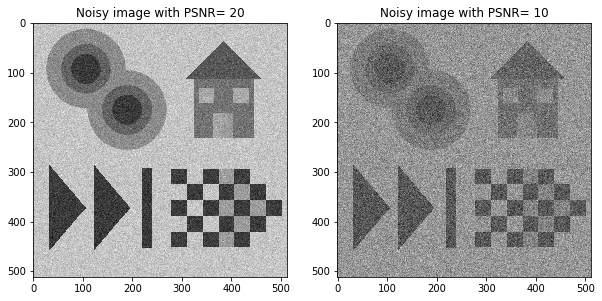

In [3]:
row, col = image1_gray.shape                                       # Image shape
Imin = image1_gray.min()                                           # Image min value
Imax = image1_gray.max()                                           # Image max value
PSNR = [20,10]                                                     # PSNR values
mean = 0                                                           # Gaussian mean value
fig, ax = plt.subplots(1, 2, figsize=(10,10))
noisy_image = np.zeros((row,col,2))                                # Noisy image initialization

for i,psnr in enumerate(PSNR):
    sigma = (Imax - Imin)/(10**(psnr/20))                          # Gaussian standard deviation
    gaussian_noise = np.random.normal(mean,sigma,(row,col))        # Gaussian noise calculation
    noisy_image[:,:,i] = image1_gray + gaussian_noise              # Noisy_image = Image + Noise
    ax[i].set_title('Noisy image with PSNR= {}'.format(psnr))
    ax[i].imshow(noisy_image[:,:,i],cmap='gray')

### 1.2. Υλοποίηση Αλγορίθμων Ανίχνευσης Ακμών

In [4]:
def CreateFilters(sigma):
    
    # Gaussian 
    n = int(2*np.ceil(3*sigma)+1)
    gauss1D = cv2.getGaussianKernel(n, sigma)  # Column vector
    gauss2D = gauss1D @ gauss1D.T              # Symmetric gaussian kernel
    
    # Laplacian-of-Gaussian
    x = np.linspace(-n/2,n/2,n)
    x, y = np.meshgrid(x,x) 
    LoG = (1/(2*pi*sigma**4))*((1/sigma**2)*(x**2+y**2)-2*np.ones(x.shape)) * np.exp(-(1/(2*sigma**2))*(x**2+y**2))
    
    return gauss2D, LoG

In [5]:
def EdgeDetect(image_gray, sigma, theta_edge, IsLinear):
    
##################################################### 1.2.1 ####################################################################
    
    gauss2D, LoG = CreateFilters(sigma)
    
##################################################### 1.2.2 ####################################################################
    
    Is = cv2.filter2D(image_gray, -1, gauss2D)               # Image Smoothing
    
    B = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)  # Kernel
    
    if IsLinear: 
        L = cv2.filter2D(image_gray, -1, LoG)                # Linear L approach 
        
    else:
        dilated_image = cv2.dilate(Is, B)                    # Perform dilation
        eroded_image = cv2.erode(Is, B)                      # Perfom erosion
        L = dilated_image + eroded_image - 2*Is              # Non Linear L approach 
    
    
##################################################### 1.2.3 ####################################################################
    
    X = (L >= 0).astype(np.uint8)                            # Binray Sign Image
    Y = cv2.dilate(X, B) - cv2.erode(X, B)                   # Border of Image x
    
##################################################### 1.2.4 ####################################################################
   
    [Isx,Isy] = np.gradient(Is)                              # Gradient of Is          
    norm = np.sqrt(Isx**2+Isy**2)                            # Norm of gradient of Is
    ZC = (Y==1) & (norm > theta_edge * norm.max())           # Zero crossings calculation
    
    return ZC.astype(np.uint8)

### 1.3. Αξιολόγηση των Αποτελεσμάτων Ανίχνευσης Ακμών

### 1.3.1

In [6]:
def RealEdgeDetect(image,theta_real_edge):
    B = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)   # Kernel
    M = cv2.dilate(image, B) - cv2.erode(image, B)            # Real edges detection
    T = (M > theta_real_edge)                                 # Real edges detection after thresholding
    #plt.figure(figsize=(7,7))
    #plt.imshow(T,cmap="gray")
    return T.astype(np.uint8)

### 1.3.2

 PSNR = 20dB
 Accuracy of Linear Laplacian Edge Detection 88.80871423271365 %
 Accuracy of Non-Linear Laplacian Edge Detection  90.07198337060711 % 

 PSNR = 10dB
 Accuracy of Linear Laplacian Edge Detection 73.67454627612672 %
 Accuracy of Non-Linear Laplacian Edge Detection  81.41305914644973 % 



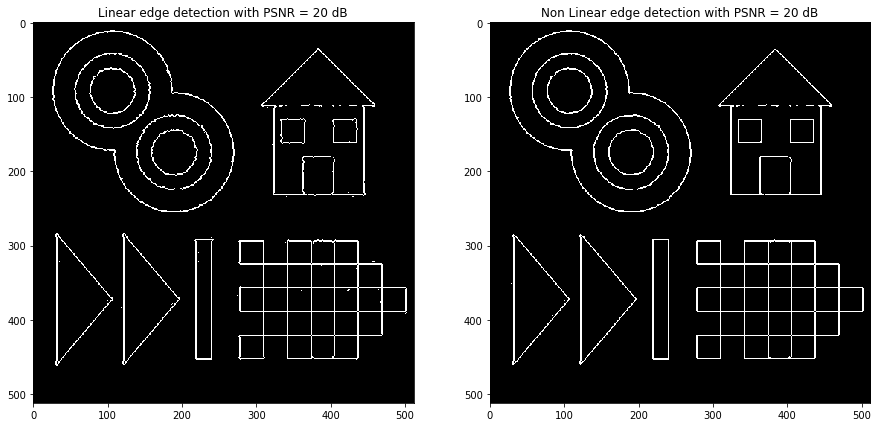

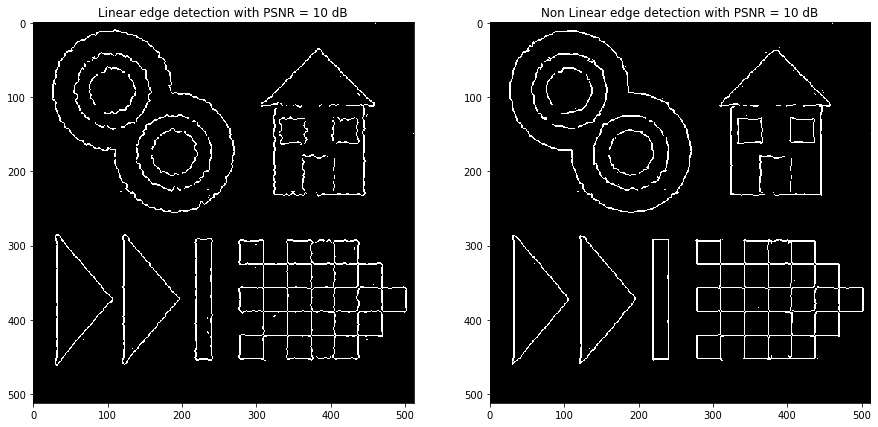

In [7]:
for i in range(0,2):
    
    T = RealEdgeDetect(image1_gray,0.0392)                                 # Real edges detection
    cardT = T.sum()                                                        # Cardinality of T
    
    # PSNR = 20 dB
    if i==0:  
        psnr = 20
        DLinear = EdgeDetect(noisy_image[:,:,i], 1.75, 0.18, 1)            # Linear approach
        DNonLinear = EdgeDetect(noisy_image[:,:,i], 1.75, 0.18, 0)         # Non Linear approach
    
    # PSNR = 10 dB
    else:     
        psnr = 10
        DLinear = EdgeDetect(noisy_image[:,:,i], 3, 0.2, 1)                 # Linear approach
        DNonLinear = EdgeDetect(noisy_image[:,:,i], 3, 0.2, 0)              # Non Linear approach
        
    fig, ax = plt.subplots(1, 2, figsize=(15,15))
    ax[0].set_title('Linear edge detection with PSNR = {} dB'.format(psnr))
    ax[0].imshow(DLinear,cmap='gray')
    ax[1].set_title('Non Linear edge detection with PSNR = {} dB'.format(psnr))
    ax[1].imshow(DNonLinear,cmap='gray')
        
    intersecLinear = T & DLinear                                             # T,D Intersection (Linear approach)
    intersecNonLinear = T & DNonLinear                                       # T,D Intersection (Non Linear approach)

    cardDLinear = DLinear.sum()                                              # Cardinality of D (Linear approach)
    cardDNonLinear = DNonLinear.sum()                                        # Cardinality of D (Non Linear approach)
    cardTDLinear = intersecLinear.sum()                                      # Cardinality of T,D Intersection (Linear approach)
    cardTDNonLinear = intersecNonLinear.sum()                                # Cardinality of T,D Intersection (Non Linear approach)
    
    CLinear = (cardTDLinear/cardDLinear + cardTDLinear/cardT)/2              # C = (Precision + Recall)/2 (Linear approach)
    CNonLinear = (cardTDNonLinear/cardDNonLinear + cardTDNonLinear/cardT)/2  # C = (Precision + Recall)/2 (Non Linear approach)
    
    print('\033[1m PSNR = {}dB'.format(psnr))
    print('\033[0m Accuracy of Linear Laplacian Edge Detection\033[1m {} %'.format(CLinear*100))
    print('\033[0m Accuracy of Non-Linear Laplacian Edge Detection \033[1m {} % \033[0m\n'.format(CNonLinear*100))

### 1.4. Εφαρμογή των Αλγορίθμων Ανίχνευσης Ακμών σε Πραγματικές εικόνες

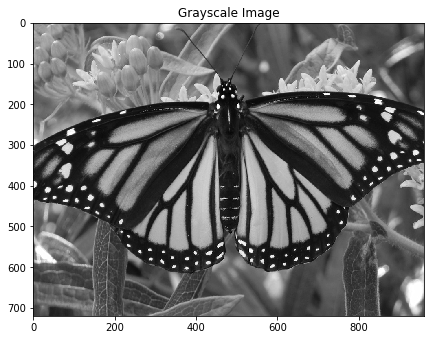

In [8]:
image2_gray = cv2.imread('butterfly.jpg',cv2.IMREAD_GRAYSCALE)  # Read image in grayscale 
image2_gray = image2_gray.astype(np.float)/255                  # Normalize to [0,1]
plt.figure(figsize=(7,7))                                       # Figure size 
plt.imshow(image2_gray, cmap='gray')                            # Show image
plt.title('Grayscale Image')
plt.show()

### 1.4.1

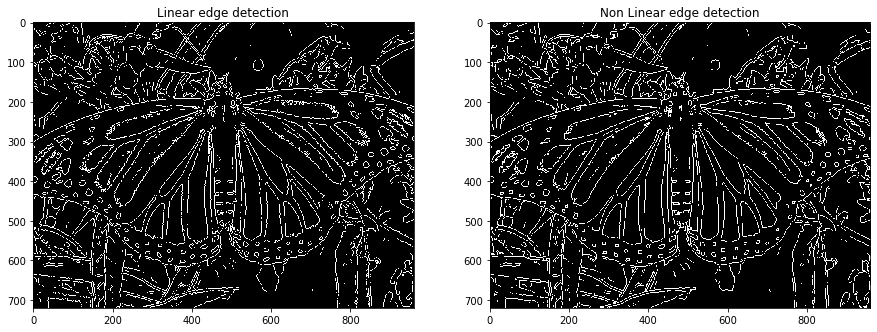

In [9]:
LinearEdges = EdgeDetect(image2_gray, 1.95, 0.1, 1)             # Linear approach
NonLinearEdges = EdgeDetect(image2_gray, 1.95, 0.1, 0)          # Non Linear approach

fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].set_title('Linear edge detection')
ax[0].imshow(LinearEdges,cmap='gray')
ax[1].set_title('Non Linear edge detection')
ax[1].imshow(NonLinearEdges,cmap='gray')
plt.show()

### Μέρος 2. Ανίχνευση Σημείων Ενδιαφέροντος (Interest Point Detection)

### 2.1. Ανίχνευση Γωνιών

In [10]:
image1_color = cv2.imread('Caravaggio2.jpg',cv2.IMREAD_COLOR)                 # Read image 
image1_gray = cv2.imread('Caravaggio2.jpg',cv2.IMREAD_GRAYSCALE)              # Read image in grayscale
image1_gray = image1_gray.astype(np.float)/255                                # Normalize to [0,1]

image2_color = cv2.imread('sunflowers.png', cv2.IMREAD_COLOR)                 # Read image
image2_gray = cv2.imread('sunflowers.png', cv2.IMREAD_GRAYSCALE)              # Read image in grayscale
image2_gray = image2_gray.astype(np.float)/255                                # Normalize to [0,1]

image1_rgb = cv2.cvtColor(image1_color, cv2.COLOR_BGR2RGB)                    # Conversion of image1 from BGR to RGB
image2_rgb = cv2.cvtColor(image2_color, cv2.COLOR_BGR2RGB)                    # Conversion of image2 from BGR to RGB 


In [11]:
def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)

In [12]:
def interest_points_visualization(I_, kp_data_, ax=None):
    '''
    Plot keypoints chosen by detectos on image.
    Args:
        I_: Image (if colored, make sure it is in RGB and not BGR).
        kp_data_: Nx3 array, as described in assignment.
        ax: Matplotlib axis to plot on (if None, a new Axes object is created).
    Returns:
        ax: Matplotlib axis where the image was plotted.
    '''
    try:
        I = np.array(I_)
        kp_data = np.array(kp_data_)
    except:
        print('Conversion to numpy arrays failed, check if the inputs (image and keypoints) are in the required format.')
        exit(2)

    try:
        assert(len(I.shape) == 2 or (len(I.shape) == 3 and I.shape[2] == 3))
    except AssertionError as e:
        print('interest_points_visualization: Image must be either a 2D matrix or a 3D matrix with the last dimension having size equal to 3.', file=sys.stderr)
        exit(2)

    try:
        assert(len(kp_data.shape) == 2 and kp_data.shape[1] == 3)
    except AssertionError as e:
        print('interest_points_visualization: kp_data must be a 2D matrix with 3 columns.', file=sys.stderr)
        exit(2)

    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))

    ax.set_aspect('equal')
    ax.imshow(I)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    for i in range(len(kp_data)):
        x, y, sigma = kp_data[i]
        circ = Circle((x, y), 3*sigma, edgecolor='lime', fill=False, linewidth=1.5)
        ax.add_patch(circ)

    return ax

In [18]:
def AngleDetect(image_gray,sigma,r,k,theta_corn):

##################################################### 2.1.1 ########################################################################

    gauss2D_sigma, _ = CreateFilters(sigma)

    gauss2D_r, _ = CreateFilters(r)

    Is = cv2.filter2D(image_gray, -1, gauss2D_sigma)                 # Smoothed image
    [Isx,Isy] = np.gradient(Is)                                      # Gradient of Is

    J1 = cv2.filter2D((Isx*Isx), -1, gauss2D_r)                      # J1 Calculation
    J2 = cv2.filter2D((Isx*Isy), -1, gauss2D_r)                      # J2 Calculation
    J3 = cv2.filter2D((Isy*Isy), -1, gauss2D_r)                      # J3 Calculation

####################################################### 2.1.2 ######################################################################
    
    lambda_pos = (1/2)*(J1+J3+np.sqrt((J1-J3)**2+4*(J2**2)))         # Positive eigenvalue
    lambda_neg = (1/2)*(J1+J3-np.sqrt((J1-J3)**2+4*(J2**2)))         # Negative eigenvalue

    #fig, ax = plt.subplots(1, 2, figsize=(15,15))
    #ax[0].set_title('Lambda positive for σ = {}'.format(round(sigma,4)))
    #ax[0].imshow(lambda_pos,cmap='gray')
    #ax[1].set_title('Lambda negative for σ = {}'.format(round(sigma,4)))
    #ax[1].imshow(lambda_neg,cmap='gray')
    
####################################################### 2.1.3 ######################################################################       
    
    R = lambda_neg*lambda_pos - k * (lambda_neg + lambda_pos)**2      # Cornerness criterion R
    
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = (R==cv2.dilate(R,B_sq))                                   # Condition 1 
    Cond2 = (R>(theta_corn*R.max()))                                  # Condition 2 (Thresholding)
    
    Corners = Cond1 & Cond2                                           # Combine both conditions
    Coordinates = np.argwhere(Corners)                                # Corner coordinates calculations
    Coordinates = np.flip(Coordinates,1)                              # Reverse coordinates
    Scale = np.ones((Coordinates.shape[0],1))*sigma                   # 1 column array with current scale
    Coordinates_Scale = np.concatenate((Coordinates, Scale), axis=1)  # Concatenate coordinates with scale
    
    
    return Coordinates_Scale, Corners

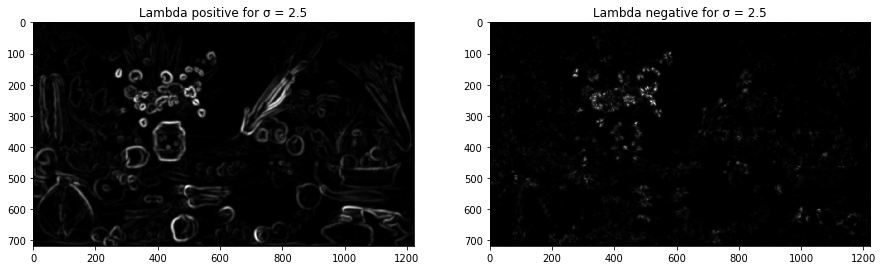

In [14]:
coordinates, corners = AngleDetect(image1_gray,2.5,2.5,0.01,0.009)

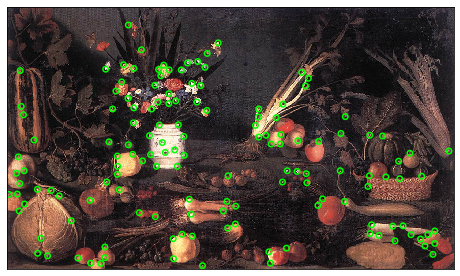

In [15]:
interest_points_visualization(image1_rgb,coordinates)

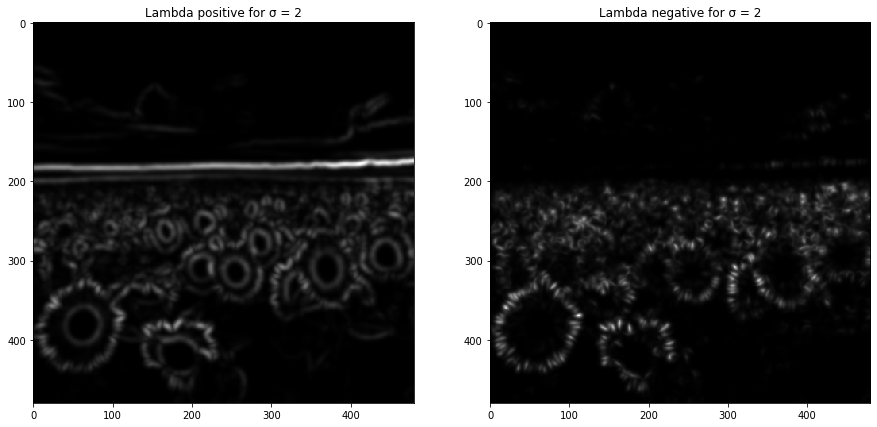

In [16]:
coordinates, corners = AngleDetect(image2_gray,2,2.5,0.009,0.011)

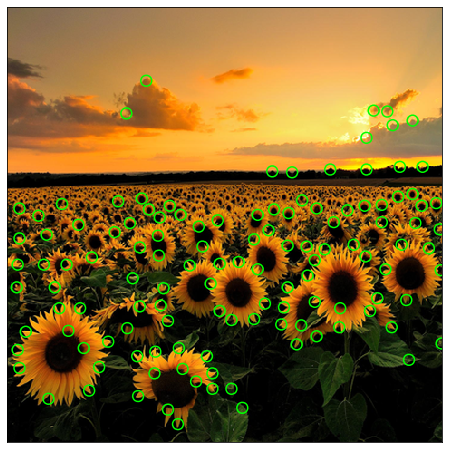

In [17]:
interest_points_visualization(image2_rgb,coordinates)

### 2.2. Πολυκλιμακωτή Ανίχνευση Γωνιών

In [19]:
def MultiScalarAngleDetect(image_gray,sigma,r,scale,N,k,theta_corn):
    
    LoG_normalised, ScalarCorners, Corners, sigma_ = [0] * N, [0] * N, [0] * N, [0] * N
    
##################################################### 2.2.1 ######################################################################## 
    
    for i in range(0,N):
        
        sigma_[i] = (scale**i)*sigma                                                     # Current sigma                                            
        r_ = (scale**i)*r                                                                # Current r
        
##################################################### 2.2.2 ########################################################################
             
        # Laplacian-of-Gaussian
        n = int(2*np.ceil(3*sigma_[i])+1)
        x = np.linspace(-n/2,n/2,n)
        x, y = np.meshgrid(x,x) 
        LoG = (1/(2*pi*sigma_[i]**4))*((1/sigma_[i]**2)*(x**2+y**2)-2*np.ones(x.shape)) * np.exp(-(1/(2*sigma_[i]**2))*(x**2+y**2))
        LoG_normalised[i] = cv2.filter2D(image_gray, -1, LoG)
        LoG_normalised[i] = sigma_[i]**2 * np.absolute(LoG_normalised[i])                 # Normalised LoG 
        
        
        ScalarCorners[i], Corners[i] = AngleDetect(image_gray,sigma_[i],r_,k,theta_corn)  # One scale corner detection
    
    # Reject certain points
    for i in range(0,N):
            
        if N==1:
            condition = np.ones(Corners[i].shape).astype(np.uint8)
        elif i==0:
            condition = (LoG_normalised[i] > LoG_normalised[i+1])
        elif i==N-1:
            condition = (LoG_normalised[i] > LoG_normalised[i-1])
        else:
            condition = (LoG_normalised[i] > LoG_normalised[i+1]) & (LoG_normalised[i] > LoG_normalised[i-1])
        
        Coordinates = np.argwhere(Corners[i] & condition)        # MultiScalarCorner coordinates calculation
        Coordinates = np.flip(Coordinates,1)                     # Reverse coordinates
        Scale = np.ones((Coordinates.shape[0],1))*sigma_[i]      # 1 column array with current scale
        current = np.concatenate((Coordinates, Scale), axis=1)   # Concatenate coordinates with scale
        
        if N==1:
            MultiScalarCorners = current
        elif i==0:
            prev = current
        else:
            MultiScalarCorners = np.concatenate((prev,current), axis=0)  
            prev = MultiScalarCorners
        
    return MultiScalarCorners

In [20]:
Corners = MultiScalarAngleDetect(image1_gray,2.5,2.5,1.9,4,0.01,0.007)  

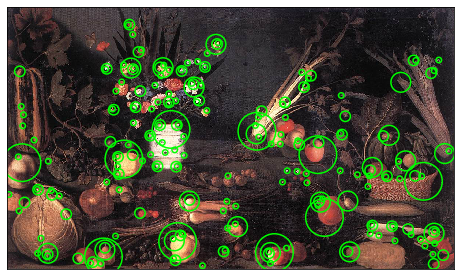

In [21]:
interest_points_visualization(image1_rgb,Corners)

In [22]:
Corners = MultiScalarAngleDetect(image2_gray,2,2.5,1.85,4,0.009,0.011)  

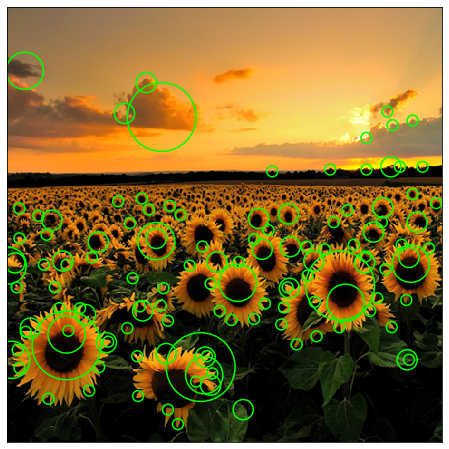

In [23]:
interest_points_visualization(image2_rgb,Corners)

### 2.3. Ανίχνευση Blobs

In [24]:
def BlobsDetect(image_gray,sigma,theta_corn):
    
##################################################### 2.3.1 ######################################################################## 
    
    gauss2D, _ = CreateFilters(sigma)
    
    Is = cv2.filter2D(image_gray, -1, gauss2D)                         # Smoothed image
    [Lx,Ly] = np.gradient(Is)                                          # Gradient of Is
    [Lxx,_] = np.gradient(Lx)                                          # Gradient of Isx
    [Lxy,Lyy] = np.gradient(Ly)                                        # Gradient of Isy
    R = Lxx*Lyy - Lxy**2                                               # R criterion
    
##################################################### 2.3.2 ######################################################################## 
    
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = (R==cv2.dilate(R,B_sq))                                    # Condition 1
    Cond2 = (R>(theta_corn*R.max()))                                   # Condition 2 (Thresholding)
    
    Blobs = Cond1 & Cond2                                              # Combine conditions
    Coordinates = np.argwhere(Blobs)                                   # Blob coordinates 
    Coordinates = np.flip(Coordinates,1)                               # Reverse coordinates
    scale = (np.ones((Coordinates.shape[0],1))*sigma)                  # 1 column array with current scale
    Coordinates_Scale = np.concatenate((Coordinates, scale), axis=1)   # Concatenate coordinates with scales
    
    return Coordinates_Scale, Blobs

In [25]:
Coords_Scale, Blobs = BlobsDetect(image1_gray,2,0.14)

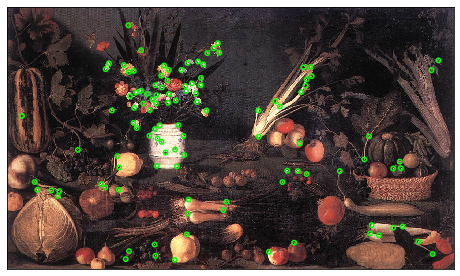

In [26]:
interest_points_visualization(image1_rgb,Coords_Scale)

In [27]:
Coords_Scale, Blobs = BlobsDetect(image2_gray,2,0.12)

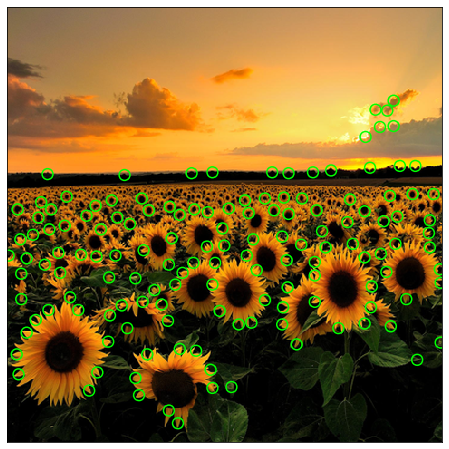

In [28]:
interest_points_visualization(image2_rgb,Coords_Scale)

### 2.4. Πολυκλιμακωτή Ανίχνευση Blobs

### 2.4.1

In [29]:
def MultiScalarBlobsDetect(image_gray,sigma,scale,N,theta_corn):
    
    LoG_normalised, ScalarBlobs, Blobs, sigma_ = [0] * N, [0] * N, [0] * N, [0] * N
    
    for i in range(0,N):
        
        sigma_[i] = (scale**i)*sigma                                             # Current sigma

        # Laplacian-of-Gaussian
        n = int(2*np.ceil(3*sigma_[i])+1)
        x = np.linspace(-n/2,n/2,n)
        x, y = np.meshgrid(x,x) 
        LoG = (1/(2*pi*sigma_[i]**4))*((1/sigma_[i]**2)*(x**2+y**2)-2*np.ones(x.shape)) * np.exp(-(1/(2*sigma_[i]**2))*(x**2+y**2))
        LoG_normalised[i] = cv2.filter2D(image_gray, -1, LoG)
        LoG_normalised[i] = sigma_[i]**2 * np.absolute(LoG_normalised[i])        # Normalised LoG 
        
        ScalarBlobs[i], Blobs[i] = BlobsDetect(image_gray,sigma_[i],theta_corn)  # One Scalar blob detection
    
    # Reject certain points
    for i in range(0,N):
            
        if N==1:
            condition = np.ones(Blobs[i].shape).astype(np.uint8)
        elif i==0:
            condition = (LoG_normalised[i] > LoG_normalised[i+1])
        elif i==N-1:
            condition = (LoG_normalised[i] > LoG_normalised[i-1])
        else:
            condition = (LoG_normalised[i] > LoG_normalised[i+1]) & (LoG_normalised[i] > LoG_normalised[i-1])
        
        Coordinates = np.argwhere(Blobs[i] & condition)                         # MultiScalarBlob coordinates calculation
        Coordinates = np.flip(Coordinates,1)                                    # Reverse coordinates
        Scale = np.ones((Coordinates.shape[0],1))*sigma_[i]                     # 1 column array with current scale
        current = np.concatenate((Coordinates, Scale), axis=1)                  # Concatenate coordinates with scale
        
        if N==1:
            MultiScalarBlobs = current
        elif i==0:
            prev = current
        else:
            MultiScalarBlobs = np.concatenate((prev,current), axis=0)
            prev = MultiScalarBlobs
        
    return MultiScalarBlobs

In [30]:
MultiScalarBlobs = MultiScalarBlobsDetect(image1_gray,2,2.2,4,0.1)

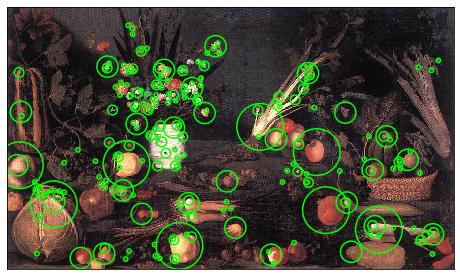

In [31]:
interest_points_visualization(image1_rgb,MultiScalarBlobs)

In [32]:
MultiScalarBlobs = MultiScalarBlobsDetect(image2_gray,2,1.85,4,0.12)

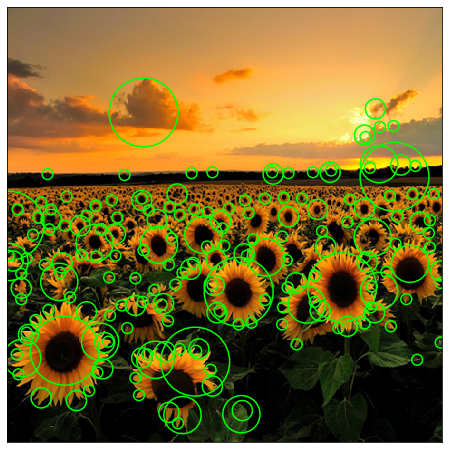

In [33]:
interest_points_visualization(image2_rgb,MultiScalarBlobs)

In [34]:
def shiftedImage(image,shiftX,shiftY,offsetx, offsety):
  
    S_A = np.roll(image,int(shiftY+offsety),axis=0)  
    S_A = np.roll(S_A, int(shiftX+offsetx),axis=1)

    S_B = np.roll(image,int(shiftY+offsety),axis=0) 
    S_B = np.roll(S_B,int(-shiftX+offsetx),axis=1)   

    S_C = np.roll(image,int(-shiftY+offsety),axis=0) 
    S_C = np.roll(S_C,int(-shiftX+offsetx),axis=1)

    S_D = np.roll(image,int(-shiftY+offsety),axis=0) 
    S_D = np.roll(S_D, int(shiftX+offsetx),axis=1)
    
    return S_A , S_B, S_C , S_D

In [35]:
def BoxFilter(image,sigma,theta_corn):
    
##################################################### 2.5.1 ######################################################################## 
    
    n = 2*np.ceil(3*sigma)+1
    pad = np.floor(n/2)+1                                    # padding factor
    image_pad = np.pad(image,int(pad),'edge')                # Image padding 
    

    for i in range(image_pad.ndim):                          # Integral image calculation (after padding)
        image_pad = image_pad.cumsum(axis=i)
        
##################################################### 2.5.2 ########################################################################  
   
    a = 2*np.floor(n/6) + 1                                  # Box filter dimension parameter
    b = 4*np.floor(n/6) + 1                                  # Box filter dimension parameter
    
    shiftA = (a-1)/2                                         # Shifting parameter
    shiftB = (b-1)/2                                         # Shifting parameter
    
    if(np.ceil((n-2*a)/3) % 2 == 1):                         # r calculation for offset parameter
        r = np.ceil((n-2*a)/3)
    else:
        r = np.floor((n-2*a)/3)
        

    # Lxx calculation by using integral image
    [S_A,S_B,S_C,S_D] = shiftedImage(image_pad,shiftA,shiftB,0,0)
    Lxx = -3*(S_C+S_A-S_B-S_D)
    [S_A,S_B,S_C,S_D] = shiftedImage(image_pad,shiftA+a,shiftB,0,0)
    Lxx = S_C+S_A-S_B-S_D + Lxx
    
    # Lyy calculation by using integral image
    [S_A,S_B,S_C,S_D] = shiftedImage(image_pad,shiftB,shiftA,0,0)
    Lyy = -3*(S_C+S_A-S_B-S_D)
    [S_A,S_B,S_C,S_D] = shiftedImage(image_pad,shiftB,shiftA+a,0,0)
    Lyy = S_C+S_A-S_B-S_D + Lyy
    
    
    # Lxy calculation by using integral image
    offsety = (r-1)/2 + shiftA
    [S_A,S_B,S_C,S_D] = shiftedImage(image_pad,shiftA,shiftA,-offsety, offsety)
    Lxy = -(S_C+S_A-S_B-S_D)
    [S_A,S_B,S_C,S_D] = shiftedImage(image_pad,shiftA,shiftA, offsety, offsety)
    Lxy = (S_C+S_A-S_B-S_D) + Lxy
    [S_A,S_B,S_C,S_D] = shiftedImage(image_pad,shiftA,shiftA, offsety,-offsety)
    Lxy = -(S_C+S_A-S_B-S_D) + Lxy
    [S_A,S_B,S_C,S_D] = shiftedImage(image_pad,shiftA,shiftA,-offsety,-offsety)
    Lxy = (S_C+S_A-S_B-S_D) + Lxy
    
##################################################### 2.5.3 ######################################################################## 
    
    R = Lxx*Lyy - (0.9*Lxy)**2                                               # R criterion       
    R = R[int(pad):R.shape[0]-int(pad),int(pad):R.shape[1]-int(pad)]         # unpadding  
    B_sq = disk_strel(n)
    Cond1 = (R==cv2.dilate(R,B_sq))                                          # Condition 1
    Cond2 = (R>(theta_corn*R.max()))                                         # Condition 2
    interest_points = Cond1 & Cond2                                          # Combine conditions
    Coordinates = np.argwhere(interest_points)                               # Coordinates calculation
    Coordinates = np.flip(Coordinates,1)                                     # Reverse coordinates
    Scale = np.ones((Coordinates.shape[0],1))*sigma                          # 1 column array with scale
    Coordinates_Scale = np.concatenate((Coordinates, Scale), axis=1)         # Concatenate coordinates with scale
    
    return Coordinates_Scale, interest_points, R
    
    

In [36]:
Coordinates_Scale, _, _ = BoxFilter(image1_gray,2,0.15)

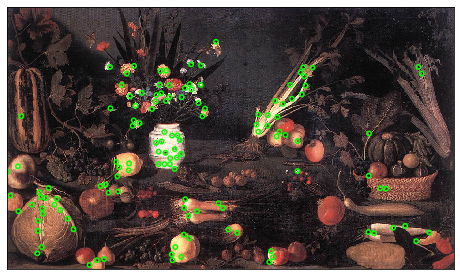

In [37]:
interest_points_visualization(image1_rgb,Coordinates_Scale)

In [38]:
Coordinates_Scale, _, _ = BoxFilter(image2_gray,2,0.22)

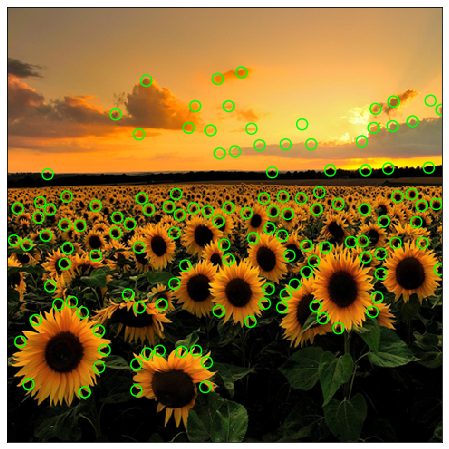

In [39]:
interest_points_visualization(image2_rgb,Coordinates_Scale)

In [40]:
def compare_methods(image):
    
    sigmas = [2.5, 4.5, 6.5, 8.5]                        # list of chosen sigmas
    
    for sigma in sigmas:
        
       #Gaussian 
        n = int(2*np.ceil(3*sigma)+1)
        gauss1D = cv2.getGaussianKernel(n, sigma)        # Column vector
        gauss2D = gauss1D @ gauss1D.T                    # Symmetric gaussian
    
       #Smoothing
        Is = cv2.filter2D(image, -1, gauss2D)            # Smoothed image
        [Lx,Ly] = np.gradient(Is)                        # Gradient of Is
        [Lxx,_] = np.gradient(Lx)                        # Gradient of Isx
        [Lxy,Lyy] = np.gradient(Ly)                      # Gradient of Isy
        
        
        R_Hessian = Lxx*Lyy - Lxy**2                      # R criterion (Hessian method)
        
        _, _, R_Box_Filter = BoxFilter(image,sigma,0.22)   # Box Filter method  
        
        #Plots
        fig, ax = plt.subplots(1, 2, figsize=(15,15))
        ax[0].set_title('Hessian with σ = {}'.format(sigma))
        ax[0].imshow(R_Hessian,cmap='gray')
        ax[1].set_title('Box Filter with σ = {}'.format(sigma))
        ax[1].imshow(R_Box_Filter,cmap='gray')

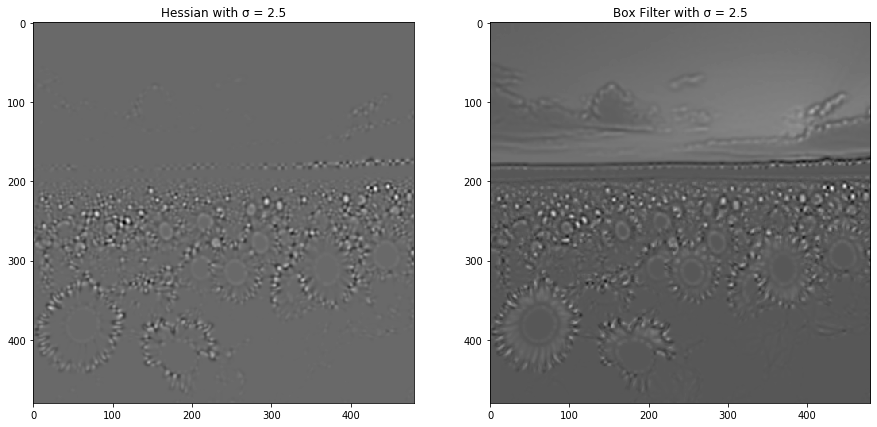

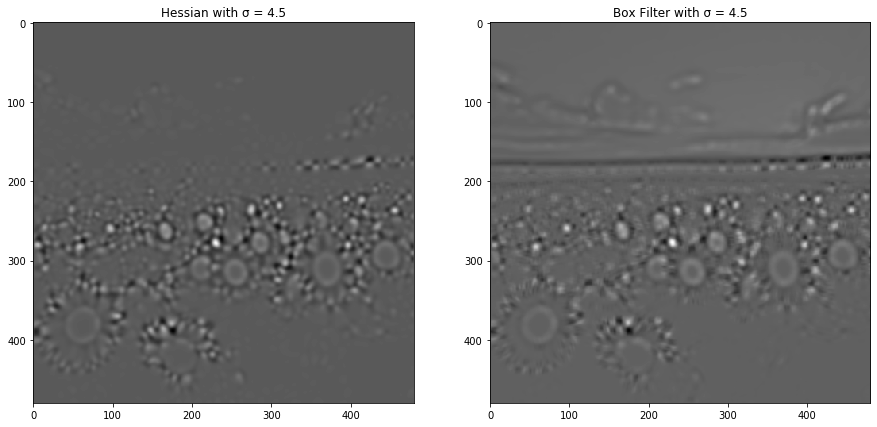

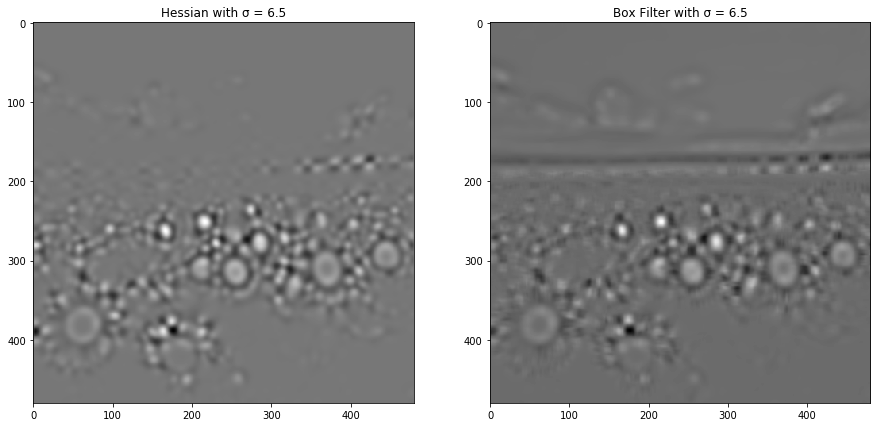

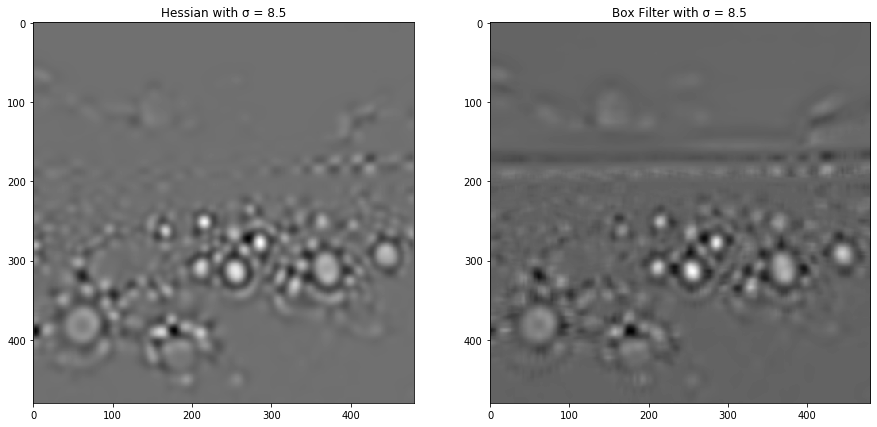

In [41]:
compare_methods(image2_gray)

### 2.5.4

In [42]:
def MultiScalarBoxFilter(image_gray,sigma,scale,N,theta_corn):
    
    LoG_normalised, ScalarBoxFilters, BoxFilters, sigma_ = [0] * N, [0] * N, [0] * N, [0] * N
    
    for i in range(0,N):
        
        sigma_[i] = (scale**i)*sigma                                               # Current sigma

        # Laplacian-of-Gaussian
        n = int(2*np.ceil(3*sigma_[i])+1)
        x = np.linspace(-n/2,n/2,n)
        x, y = np.meshgrid(x,x) 
        LoG = (1/(2*pi*sigma_[i]**4))*((1/sigma_[i]**2)*(x**2+y**2)-2*np.ones(x.shape)) * np.exp(-(1/(2*sigma_[i]**2))*(x**2+y**2))
        LoG_normalised[i] = cv2.filter2D(image_gray, -1, LoG)
        LoG_normalised[i] = sigma_[i]**2 * np.absolute(LoG_normalised[i])          # Normalised LoG
        
        ScalarBoxFilters[i], BoxFilters[i], _  = BoxFilter(image_gray,sigma_[i],theta_corn)         
    
    for i in range(0,N):
            
        if N==1:
            condition = np.ones(BoxFilters[i].shape).astype(np.uint8)
        elif i==0:
            condition = (LoG_normalised[i] > LoG_normalised[i+1])
        elif i==N-1:
            condition = (LoG_normalised[i] > LoG_normalised[i-1])
        else:
            condition = (LoG_normalised[i] > LoG_normalised[i+1]) & (LoG_normalised[i] > LoG_normalised[i-1])
        
        Coordinates = np.argwhere(BoxFilters[i] & condition)                      # Coordinates calculation
        Coordinates = np.flip(Coordinates,1)                                      # Reverse coordinates
        Scale = np.ones((Coordinates.shape[0],1))*sigma_[i]                       # 1 column array with current scale 
        current = np.concatenate((Coordinates, Scale), axis=1)                    # Concatenate coordinates with scale 
        
        if N==1:
            MultiScalarBoxFilters = current
        elif i==0:
            prev = current
        else:
            MultiScalarBoxFilters = np.concatenate((prev,current), axis=0)
            prev = MultiScalarBoxFilters
        
    return MultiScalarBoxFilters

In [43]:
MultiScalarBoxFilters = MultiScalarBoxFilter(image1_gray,2,2.1,4,0.11)

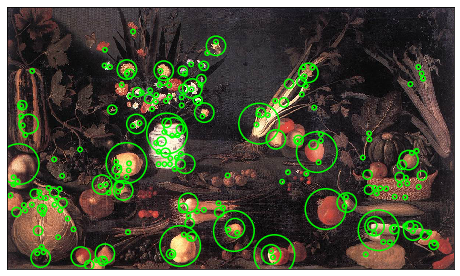

In [44]:
interest_points_visualization(image1_rgb,MultiScalarBoxFilters)

In [45]:
MultiScalarBoxFilters = MultiScalarBoxFilter(image2_gray,2,1.75,4,0.2)

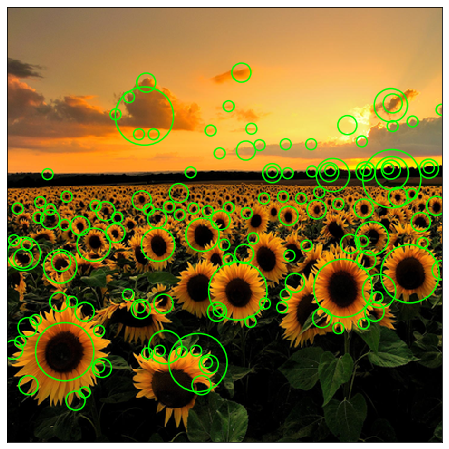

In [46]:
interest_points_visualization(image2_rgb,MultiScalarBoxFilters)

### Μέρος 3. Εφαρμογές σε Ταίριασμα και Κατηγοριοποίηση Εικόνων με Χρήση Τοπικών Περιγραφητών στα Σημεία Ενδιαφέροντος

### 3.1. Ταίριασμα Εικόνων υπό Περιστροφή και Αλλαγή Κλίμακας

In [2]:
! python our_test_matching_evaluation.py

Avg. Scale Error for Image 1 with AngleDetect and SURF descriptor: 0.002
Avg. Scale Error for Image 1 with AngleDetect and HOG  descriptor: 0.132
Avg. Theta Error for Image 1 with AngleDetect and SURF descriptor: 0.156
Avg. Theta Error for Image 1 with AngleDetect and HOG  descriptor: 16.429
Avg. Scale Error for Image 2 with AngleDetect and SURF descriptor: 0.002
Avg. Scale Error for Image 2 with AngleDetect and HOG  descriptor: 0.206
Avg. Theta Error for Image 2 with AngleDetect and SURF descriptor: 0.185
Avg. Theta Error for Image 2 with AngleDetect and HOG  descriptor: 17.362
Avg. Scale Error for Image 3 with AngleDetect and SURF descriptor: 0.003
Avg. Scale Error for Image 3 with AngleDetect and HOG  descriptor: 0.156
Avg. Theta Error for Image 3 with AngleDetect and SURF descriptor: 0.324
Avg. Theta Error for Image 3 with AngleDetect and HOG  descriptor: 18.316

Avg. Scale Error for Image 1 with MultiScalarAngleDetect and SURF descriptor: 0.001
Avg. Scale Error for Image 1 with Mu

### 3.2. Κατηγοριοποίηση Εικόνων

Εξάγουμε τα ποσοστά ακριβείας για κάθε συνδυασμό πολυκλιμακωτού ανιχνευτή και περιγραφητή τρέχοντας τοπικά (στο cmd) το αρχείο example_classification.py, το οποίο τροποποιούμε κάθε φορά κατάλληλα. Τα αποτέλεσματα βρίσκονται στους φακέλους BagOfWordsAccuracy και MyBagOfWordsAccuracy για την έτοιμη και την δική μας υλοποίηση BoVW αντίστοιχα.  